In [66]:
import os
# Отключает все логи TensorFlow (0 - все, 1 - предупреждения, 2 - ошибки, 3 - критичные ошибки)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [67]:
from sklearn import datasets
import pandas as pd
import numpy as np
from typing import List, Union
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
import pandas as pd
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, IsolationForest
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
import time
from gower import gower_matrix
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
from collections import Counter
from scipy.spatial.distance import pdist, squareform
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.svm import OneClassSVM
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import mutual_info_classif
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

In [3]:
loan = pd.read_csv('content/loan_data.csv')

In [4]:
loan

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,27.0,male,Associate,47971.0,6,RENT,15000.0,MEDICAL,15.66,0.31,3.0,645,No,1
44996,37.0,female,Associate,65800.0,17,RENT,9000.0,HOMEIMPROVEMENT,14.07,0.14,11.0,621,No,1
44997,33.0,male,Associate,56942.0,7,RENT,2771.0,DEBTCONSOLIDATION,10.02,0.05,10.0,668,No,1
44998,29.0,male,Bachelor,33164.0,4,RENT,12000.0,EDUCATION,13.23,0.36,6.0,604,No,1


In [5]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

In [90]:
# Кодируем категориальные переменные (Label Encoding)
df_encoded = loan.copy()
label_encoders = {}

categorical_columns = df_encoded.select_dtypes(include=['object']).columns
for col in categorical_columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le

# Убираем целевую переменную 
X = df_encoded.drop(columns=['loan_status','person_age', 'credit_score', 'person_gender', 'person_emp_exp', 'person_education', 'cb_person_cred_hist_length', 'loan_intent'])
y = df_encoded.loan_status

scaler = StandardScaler()
X_scaler = scaler.fit_transform(X)
df_X_scaler = pd.DataFrame(X_scaler, columns=X.columns) 


Z = df_encoded.drop(columns=['loan_status'])
Z_scaler = scaler.fit_transform(Z)
df_z_scaler = pd.DataFrame(Z_scaler, columns=Z.columns) 

In [60]:
# Рассчитаем VIF (коэффициент инфляции дисперсии)
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns 
vif_data["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]

# Выводим признаки с VIF > 10
vif_data[vif_data["VIF"] > 10]

,Feature,VIF


In [86]:
# Рассчитаем VIF (коэффициент инфляции дисперсии)
vif_data = pd.DataFrame()
vif_data["Feature"] = Z.columns 
vif_data["VIF"] = [variance_inflation_factor(Z, i) for i in range(Z.shape[1])]

# Выводим признаки с VIF > 10
vif_data[vif_data["VIF"] > 10]

,Feature,VIF
0,person_age,166.208134
4,person_emp_exp,12.091587
8,loan_int_rate,15.071714
10,cb_person_cred_hist_length,12.140311
11,credit_score,92.788409


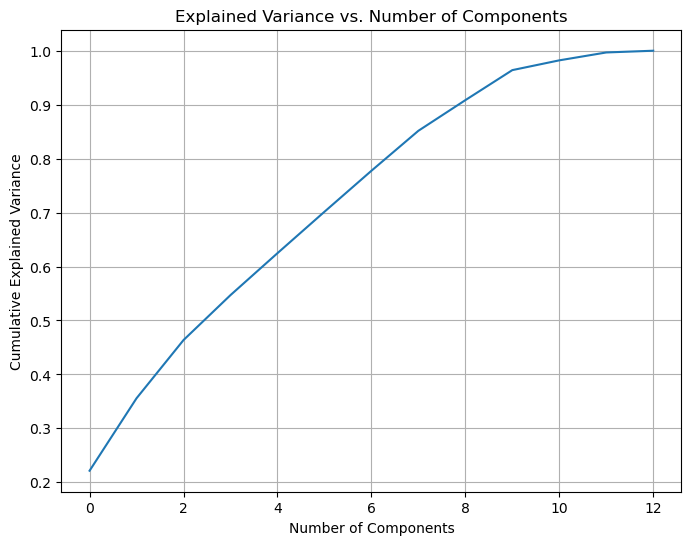

In [88]:
pca = PCA().fit(Z_scaler)

# Визуализация
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

In [ ]:
Z_scaler

In [ ]:
pca = PCA().fit(X_scaler)

# Визуализация
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

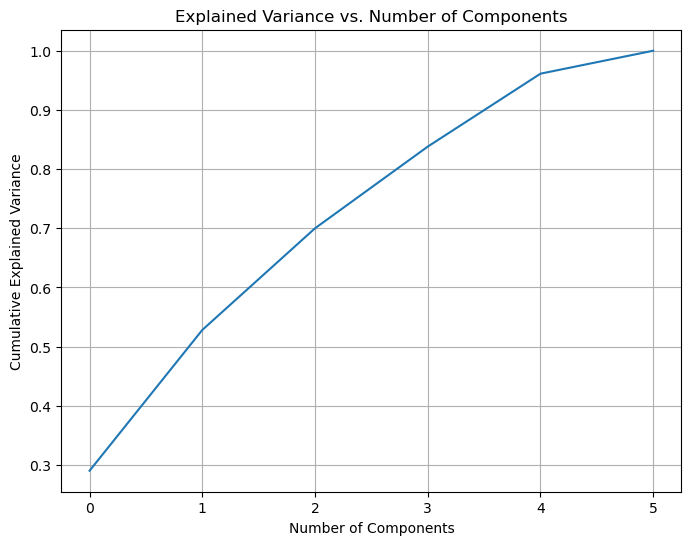

In [61]:
pca = PCA().fit(X_scaler)

# Визуализация
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

In [78]:
df_X_scaler

,person_income,person_home_ownership,loan_amnt,loan_int_rate,loan_percent_income,previous_loan_defaults_on_file,PCA1,PCA2,PCA3
0,-0.104090,0.904822,4.024953,1.683039,4.016394,-1.016040,5.918109,1.009105,-0.548449
1,-0.846005,0.210609,-1.359209,0.044782,-0.684829,0.984213,-1.393377,-1.080834,-0.319267
2,-0.844065,-1.177817,-0.646600,0.625557,3.443074,-1.016040,2.351841,-0.414316,-0.852024
3,-0.007039,0.904822,4.024953,1.417829,3.443074,-1.016040,5.443310,1.090261,-0.457592
4,-0.176371,0.904822,4.024953,1.095549,4.475050,-1.016040,6.031498,1.029246,-1.141475
...,...,...,...,...,...,...,...,...,...
44995,-0.402231,0.904822,0.857799,1.562184,1.952442,-1.016040,2.815306,-0.723566,0.470801
44996,-0.180537,0.904822,-0.092348,1.028407,0.003155,-1.016040,0.813008,-1.015301,1.104163
44997,-0.290681,0.904822,-1.078758,-0.331212,-1.028821,-1.016040,-0.846559,-1.433127,0.698160
44998,-0.586348,0.904822,0.382726,0.746412,2.525762,-1.016040,2.678999,-0.978955,-0.300107


In [62]:
# pca = PCA().fit(Z)

# # Получаем веса признаков для первой компоненты
# first_component = pca.components_[0]

# # Создаем DataFrame для удобства анализа
# feature_importance = pd.DataFrame({'Feature': ['person_gender', 'person_education', 'person_income',
#        'person_emp_exp', 'person_home_ownership', 'loan_amnt', 'loan_intent',
#        'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
#         'previous_loan_defaults_on_file'], 'Weight': first_component})

# # Сортируем по абсолютному значению вклада в компоненту
# feature_importance = feature_importance.reindex(feature_importance['Weight'].abs().sort_values(ascending=False).index)

# print(feature_importance)

# # Визуализация
# plt.figure(figsize=(8,6))
# plt.plot(np.cumsum(pca.explained_variance_ratio_))
# plt.xlabel('Number of Components')
# plt.ylabel('Cumulative Explained Variance')
# plt.title('Explained Variance vs. Number of Components')
# plt.grid(True)
# plt.show()

# cumulative_variance = pca.explained_variance_ratio_.cumsum()
# n_components_for_95 = (cumulative_variance >= 0.99).argmax() + 1
# print(f"Число компонент для объяснения 99% дисперсии: {n_components_for_95}")

In [91]:
# Вычисляем MI
mi_scores = mutual_info_regression(Z_scaler, y)

# Оформляем результат в DataFrame
mi_scores = pd.Series(mi_scores, index=df_z_scaler.columns)
mi_scores = mi_scores.sort_values(ascending=False)

# Выводим топ-10 признаков
print(mi_scores)

previous_loan_defaults_on_file    0.190973
person_income                     0.092186
loan_percent_income               0.079805
loan_int_rate                     0.072073
person_home_ownership             0.032941
loan_amnt                         0.016423
loan_intent                       0.007330
person_emp_exp                    0.004862
person_age                        0.000852
person_gender                     0.000702
person_education                  0.000000
cb_person_cred_hist_length        0.000000
credit_score                      0.000000
dtype: float64


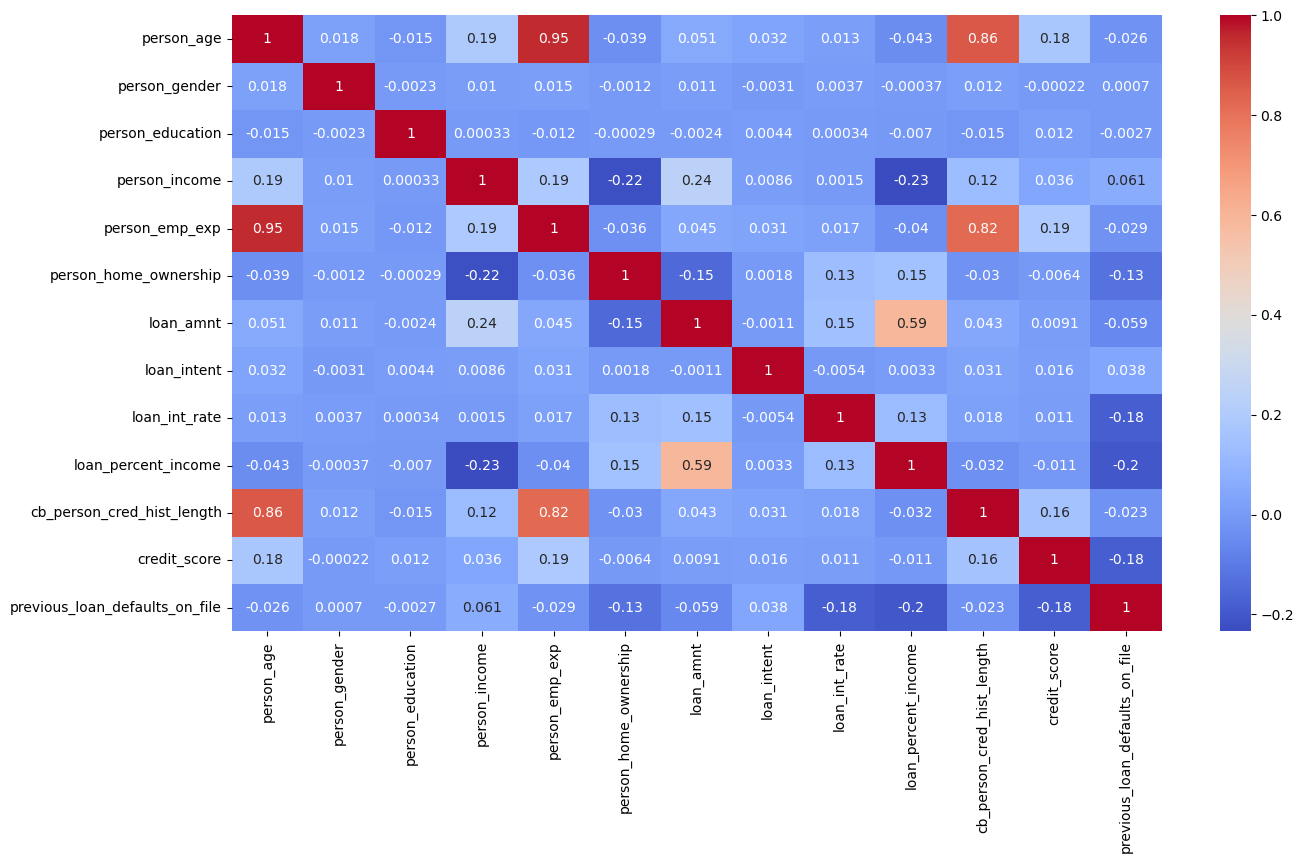

In [24]:
plt.figure(figsize=(15, 8))
sns.heatmap(X.corr(), annot=True, cmap="coolwarm")
plt.show()

In [80]:
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_scaler)

df_X_scaler["PCA1"] = X_pca[:, 0]
df_X_scaler["PCA2"] = X_pca[:, 1]
df_X_scaler["PCA3"] = X_pca[:, 2]
df_X_scaler["PCA4"] = X_pca[:, 3]

In [81]:
df_X_scaler

,person_income,person_home_ownership,loan_amnt,loan_int_rate,loan_percent_income,previous_loan_defaults_on_file,PCA1,PCA2,PCA3,PCA4
0,-0.104090,0.904822,4.024953,1.683039,4.016394,-1.016040,5.918109,1.009105,-0.548449,0.735617
1,-0.846005,0.210609,-1.359209,0.044782,-0.684829,0.984213,-1.393377,-1.080834,-0.319267,0.700177
2,-0.844065,-1.177817,-0.646600,0.625557,3.443074,-1.016040,2.351841,-0.414316,-0.852024,-1.023329
3,-0.007039,0.904822,4.024953,1.417829,3.443074,-1.016040,5.443310,1.090261,-0.457592,0.611083
4,-0.176371,0.904822,4.024953,1.095549,4.475050,-1.016040,6.031498,1.029246,-1.141475,0.455942
...,...,...,...,...,...,...,...,...,...,...
44995,-0.402231,0.904822,0.857799,1.562184,1.952442,-1.016040,2.815306,-0.723566,0.470801,0.341452
44996,-0.180537,0.904822,-0.092348,1.028407,0.003155,-1.016040,0.813008,-1.015301,1.104163,-0.005572
44997,-0.290681,0.904822,-1.078758,-0.331212,-1.028821,-1.016040,-0.846559,-1.433127,0.698160,-0.759017
44998,-0.586348,0.904822,0.382726,0.746412,2.525762,-1.016040,2.678999,-0.978955,-0.300107,-0.097867


In [82]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)

In [83]:
# Директория для сохранения моделей
os.makedirs("models/loan/pca", exist_ok=True)

# Создаем функцию для создания модели
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(X_train.shape[1],)),  # Входной слой
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')  
    ])
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])
    return model


def train_on_device(device):
    with tf.device(device):
        print(f"Обучение модели на {device}...")
        model = create_model()

        # Функции callbacks
        callbacks_filtered = [
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
        ]
        
        # Запускаем обучение и измеряем время
        start_time = time.time()
        history = model.fit(X_train, y_train, epochs=200, batch_size=32, 
                            validation_data=(X_test, y_test), 
                            callbacks=callbacks_filtered, verbose=1)
        end_time = time.time()

        # Возвращаем время, потраченное на обучение
        training_time = end_time - start_time

        return training_time, history



In [84]:
cpu_device = '/CPU:0'
cpu_training_time, cpu_history = train_on_device(cpu_device)

Обучение модели на /CPU:0...
Epoch 1/200
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8809 - loss: 0.2541 - val_accuracy: 0.8944 - val_loss: 0.2290 - learning_rate: 0.0100
Epoch 2/200
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8939 - loss: 0.2288 - val_accuracy: 0.8979 - val_loss: 0.2212 - learning_rate: 0.0100
Epoch 3/200
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 2s 976us/step - accuracy: 0.8982 - loss: 0.2223 - val_accuracy: 0.8984 - val_loss: 0.2224 - learning_rate: 0.0100
Epoch 4/200
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 2s 984us/step - accuracy: 0.9019 - loss: 0.2186 - val_accuracy: 0.9030 - val_loss: 0.2146 - learning_rate: 0.0100
Epoch 5/200
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 2s 942us/step - accuracy: 0.8976 - loss: 0.2207 - val_accuracy: 0.8986 - val_loss: 0.2173 - learning_rate: 0.0100
Epoch 6/200
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9009 - loss: 0.2183 - val_accuracy: 0.9022 - val_loss: 0.2138 - learning_rate: 0.0100
Epoch 7/200
2250/2250 ━━━━━━━━━━━━━

NameError: name 'send_to_telegram' is not defined